### Student Information
Name:陳玠霖

Student ID:111065553

GitHub ID:TwPanTsu

Kaggle name:PanTsuEzPz

Kaggle private scoreboard snapshot:

[Snapshot](img/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

In [319]:
### Begin Assignment Here
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import keras
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\datalab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.1 Load data

In [320]:
data_identification = pd.read_csv('data/data_identification.csv')
emotion = pd.read_csv('data/emotion.csv')
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
print(data_identification[0:5])
print(emotion[0:5])
print(sampleSubmission[0:5])

   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train
   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation
         id   emotion
0  0x2c7743  surprise
1  0x2c1eed  surprise
2  0x2826ea  surprise
3  0x356d9a  surprise
4  0x20fd95  surprise


In [321]:
len(data_identification)

1867535

In [322]:
#loads data (a lots of time)
tweets = []
for line in open('data/tweets_DM.json', 'r'):
    tweets.append(json.loads(line))

In [323]:
#example
tweets[0]

{'_score': 391,
 '_index': 'hashtag_tweets',
 '_source': {'tweet': {'hashtags': ['Snapchat'],
   'tweet_id': '0x376b20',
   'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
 '_crawldate': '2015-05-23 11:42:47',
 '_type': 'tweets'}

In [324]:
#find identity:train or test?
findiden={}
for i in range(len(data_identification)):
    findiden[data_identification['tweet_id'][i]] = data_identification['identification'][i]
#example
findiden['0x28cc61']

'test'

In [325]:
#find emotion : 8 type from train data
findemo={}
for i in range(len(emotion)):
    findemo[emotion['tweet_id'][i]] = emotion['emotion'][i]
#example
findemo['0x3140b1']

'sadness'

In [326]:
#find sam: 8 type from test data
findsam={}
for i in range(len(sampleSubmission)):
    findsam[sampleSubmission['id'][i]] = sampleSubmission['emotion'][i]
#example
findsam['0x2c7743']

'surprise'

In [327]:
#create full dataframe for test and train
fullid_test=[]
fullid_train=[]
fulltext_test=[]
fulltext_train=[]
fullemo_test=[]
fullemo_train=[]

for i in range (len(tweets)):
    if (findiden[tweets[i]['_source']['tweet']['tweet_id']] == 'test'):
        fullid_test.append(tweets[i]['_source']['tweet']['tweet_id'])
        fulltext_test.append(tweets[i]['_source']['tweet']['text'])
        fullemo_test.append(findsam[tweets[i]['_source']['tweet']['tweet_id']])
    elif(findiden[tweets[i]['_source']['tweet']['tweet_id']] == 'train'):
        fullid_train.append(tweets[i]['_source']['tweet']['tweet_id'])
        fulltext_train.append(tweets[i]['_source']['tweet']['text'])
        fullemo_train.append(findemo[tweets[i]['_source']['tweet']['tweet_id']])
Ser1_test = pd.Series(fullid_test)
Ser2_test = pd.Series(fulltext_test)
Ser3_test = pd.Series(fullemo_test)
Ser1_train = pd.Series(fullid_train)
Ser2_train = pd.Series(fulltext_train)
Ser3_train = pd.Series(fullemo_train)
df_test = pd.DataFrame({'id':Ser1_test, 'text':Ser2_test, 'emotion':Ser3_test})
df_train = pd.DataFrame({'id':Ser1_train, 'text':Ser2_train, 'emotion':Ser3_train})

In [328]:
df_train[0:5]
#inside train set

,id,text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation


In [329]:
df_test[0:5]
#inside test set

,id,text,emotion
0,0x28b412,"Confident of your obedience, I write to you, k...",surprise
1,0x2de201,"""Trust is not the same as faith. A friend is s...",surprise
2,0x218443,When do you have enough ? When are you satisfi...,surprise
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",surprise
4,0x26289a,"In these tough times, who do YOU turn to as yo...",surprise


In [330]:
# shuffle dataset
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)
print("Shape of Training df: ", df_train.shape)
print("Shape of Testing df: ", df_test.shape)

Shape of Training df:  (1455563, 3)
Shape of Testing df:  (411972, 3)


In [331]:
df_train[0:5]

,id,text,emotion
1417651,0x29beb0,Ohhh nooooos @FigoToronto is outta pizza. <LH>...,sadness
566130,0x263bc2,"""So, whether you eat or drink, or whatever you...",anticipation
1360240,0x356113,"people getting viral tweets making the same ""I...",joy
606897,0x1f0c4f,"<LH> Sunday # may God bless u all Amen,Ami o,Amin",joy
1126198,0x345fee,@Douglie007 @HDRetrovision Guessing the first ...,anticipation


In [332]:
df_test[0:5]

,id,text,emotion
396412,0x279fa8,That moment your 3 year old son randomly tells...,surprise
380439,0x2a396c,@AbbiTRS Personally I think it was very thrift...,surprise
34835,0x1c8173,@modern_rock @HawaiianAir That sucks.... trave...,surprise
25573,0x2d8b92,And my niggas just pulled up on some convoy sh...,surprise
383652,0x2beef4,Exactly 4 more weeks till FIFA 18 release ⚽ <LH>,surprise


In [333]:
##top 100 feature
count_vectorizer = CountVectorizer(max_features=100)
df_train_counts = count_vectorizer.fit_transform(df_train.text)
term_frequencies_train = np.asarray(df_train_counts.sum(axis=0))
train_feature_names = count_vectorizer.get_feature_names_out()
df_test_counts = count_vectorizer.fit_transform(df_test.text)
term_frequencies_test = np.asarray(df_test_counts.sum(axis=0))
test_feature_names = count_vectorizer.get_feature_names_out()

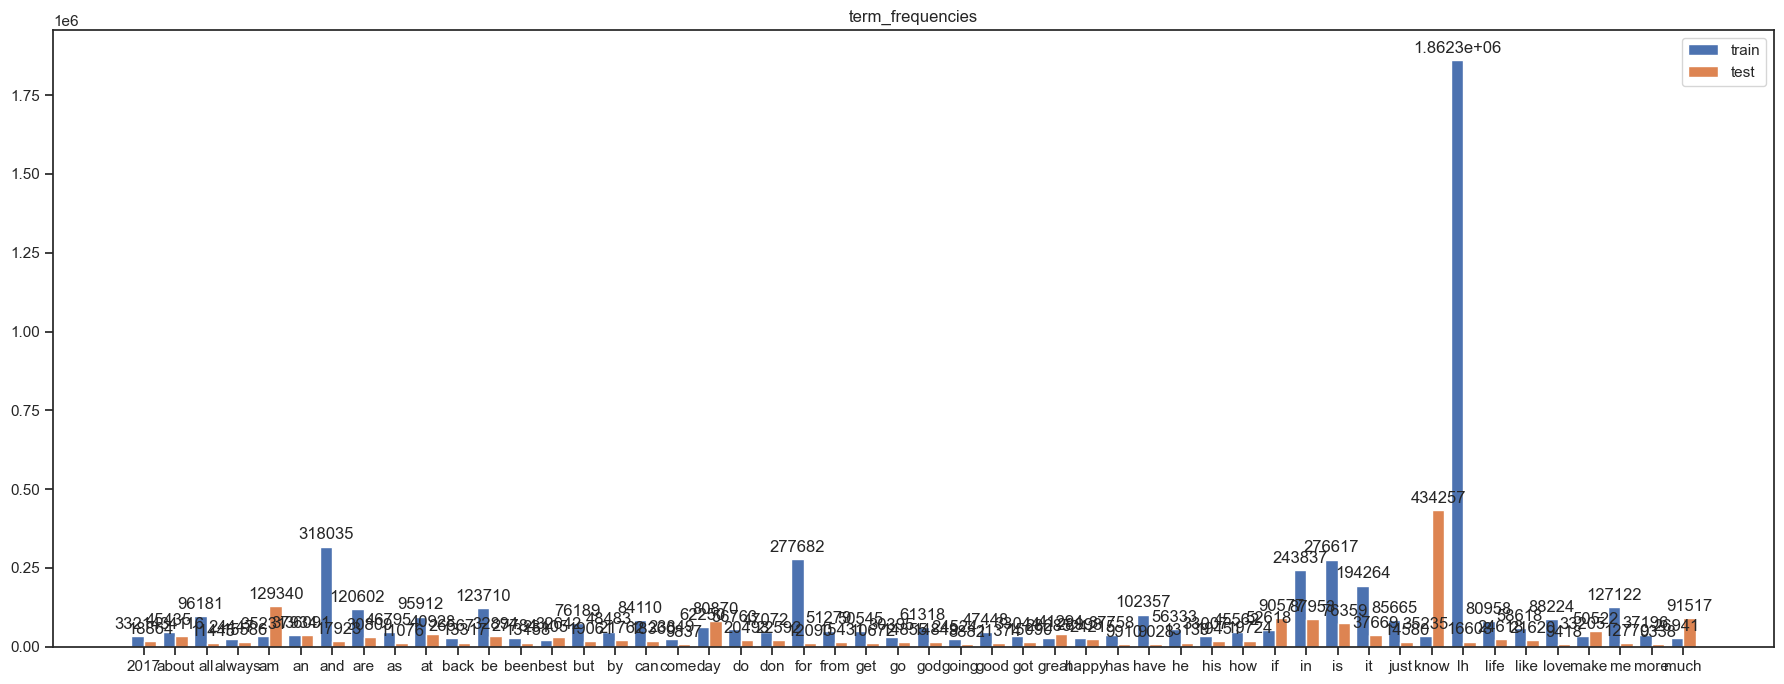

In [334]:
##graph
x = np.arange(50)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(18,7))
rects1 = ax.bar(x - width/2, term_frequencies_train[0][0:50], width, label='train')
rects2 = ax.bar(x + width/2, term_frequencies_test[0][0:50], width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('term_frequencies')
ax.set_xticks(x, train_feature_names[0:50])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

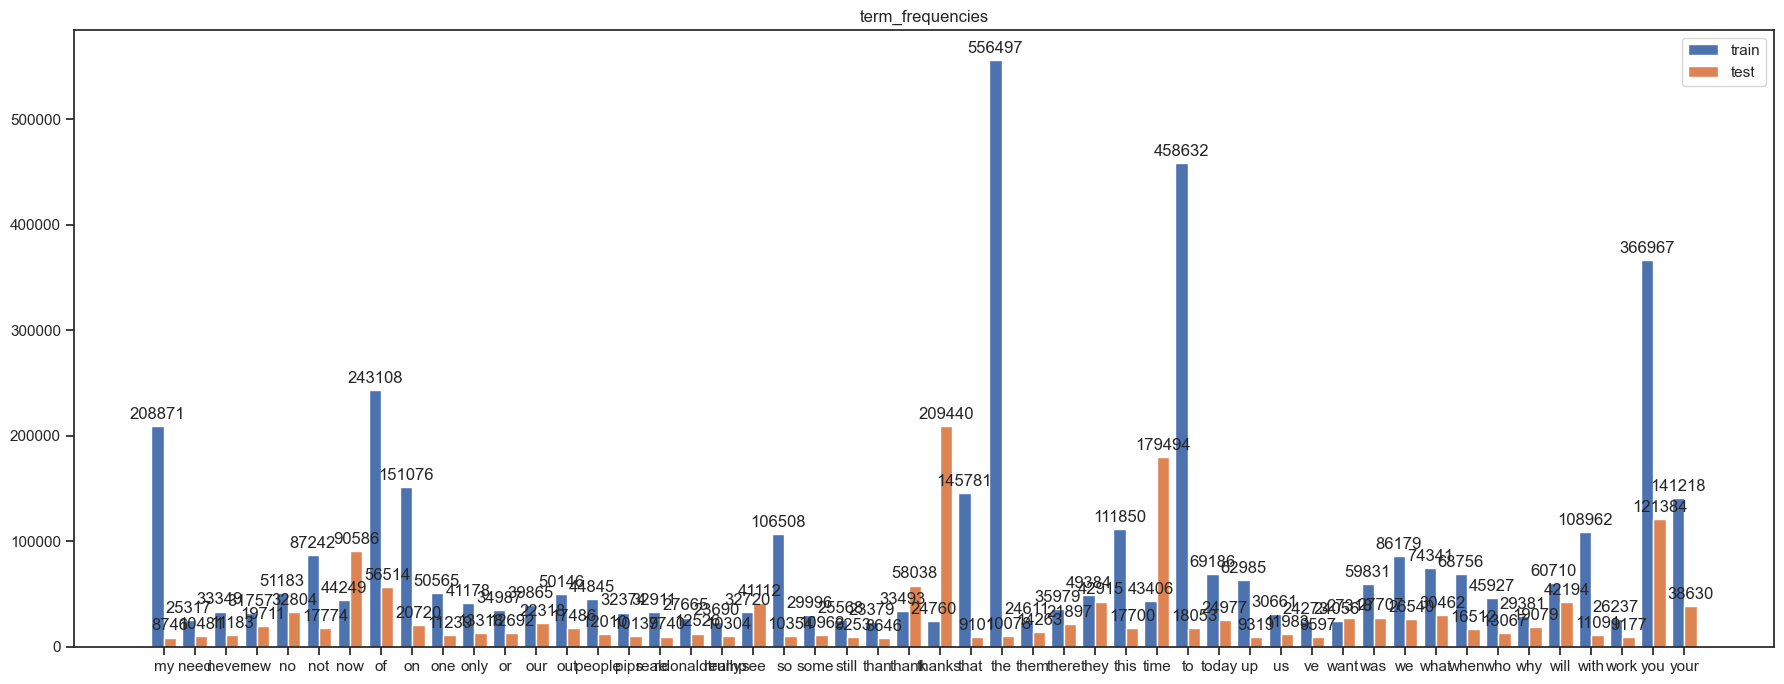

In [335]:
##graph
x = np.arange(50)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(18,7))
rects1 = ax.bar(x - width/2, term_frequencies_train[0][50:100], width, label='train')
rects2 = ax.bar(x + width/2, term_frequencies_test[0][50:100], width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('term_frequencies')
ax.set_xticks(x, train_feature_names[50:100])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

### 1.2 Save data

In [336]:
## save to csv
df_train.to_csv('train_data.csv', index=False) 
df_test.to_csv('test_data.csv', index=False) 
## save to pickle file
df_train.to_pickle("df_train.pkl") 
df_test.to_pickle("df_test.pkl")
## load a pickle file
df_train = pd.read_pickle("df_train.pkl")
df_test = pd.read_pickle("df_test.pkl")

### 1.3 Exploratory data analysis (EDA)

In [337]:
# group to find distribution
df_train.groupby(['emotion']).count()['text']

emotion
anger            39867
anticipation    248935
disgust         139101
fear             63999
joy             516017
sadness         193437
surprise         48729
trust           205478
Name: text, dtype: int64

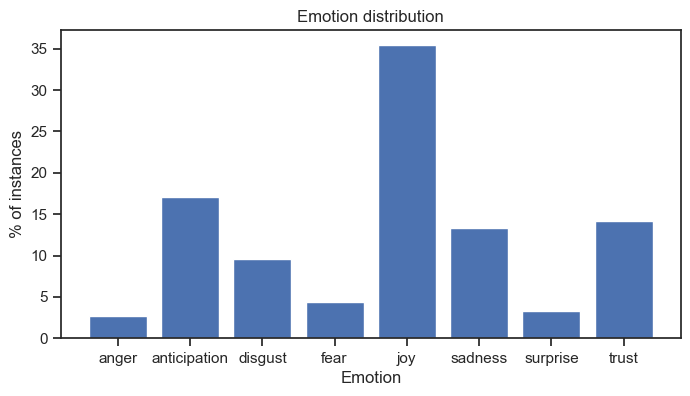

In [338]:
# the histogram of the train data
labels = df_train['emotion'].unique()
post_total = len(df_train)
df1 = df_train.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

In [339]:
##I think its unfair to having one data that have 35%
##so i want to try having a uniform disturbution
emo_type=['anger', 'anticipation', 'disgust', 'fear', 'sadness', 'surprise', 'trust', 'joy']
fliter = (df_train["emotion"] == "anger")
df_train_anger = df_train[fliter]
fliter = (df_train["emotion"] == "anticipation")
df_train_anticipation = df_train[fliter]
fliter = (df_train["emotion"] == "disgust")
df_train_disgust = df_train[fliter]
fliter = (df_train["emotion"] == "fear")
df_train_fear = df_train[fliter]
fliter = (df_train["emotion"] == "sadness")
df_train_sadness = df_train[fliter]
fliter = (df_train["emotion"] == "surprise")
df_train_surprise = df_train[fliter]
fliter = (df_train["emotion"] == "trust")
df_train_trust = df_train[fliter]
fliter = (df_train["emotion"] == "joy")
df_train_joy = df_train[fliter]
print(len(df_train_anger))
print(len(df_train_anticipation))
print(len(df_train_disgust))
print(len(df_train_fear))
print(len(df_train_sadness))
print(len(df_train_surprise))
print(len(df_train_trust))
print(len(df_train_joy))

39867
248935
139101
63999
193437
48729
205478
516017


In [340]:
##anger has smallest data(39867) so others should be too.
df_train_anger = df_train_anger[0:39867]
df_train_anticipation = df_train_anticipation[0:39867]
df_train_disgust = df_train_disgust[0:39867]
df_train_fear = df_train_fear[0:39867]
df_train_sadness = df_train_sadness[0:39867]
df_train_surprise = df_train_surprise[0:39867]
df_train_trust = df_train_trust[0:39867]
df_train_joy = df_train_joy[0:39867]
df_train=pd.concat([df_train_anger, df_train_anticipation, df_train_disgust, df_train_fear, df_train_sadness, df_train_surprise, df_train_trust, df_train_joy ],axis=0)
print(len(df_train))

318936


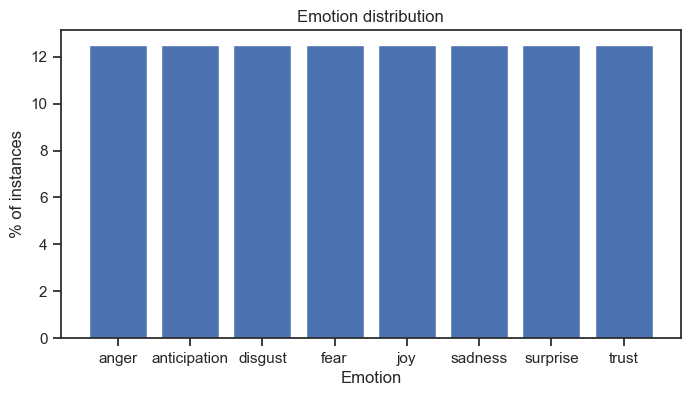

In [341]:
# the histogram of the train data
labels = df_train['emotion'].unique()
post_total = len(df_train)
df1 = df_train.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

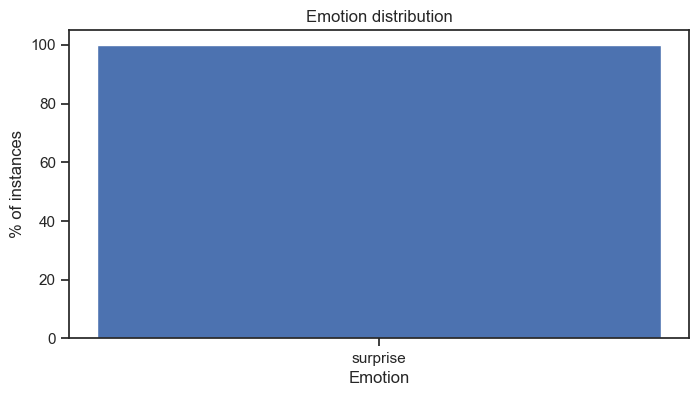

In [342]:
# the histogram of the test data
labels = df_test['emotion'].unique()
post_total = len(df_test)
df1 = df_test.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.show()

### 2. Feature engineering

In [343]:
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(df_train['text'])

BOW_500_train = BOW_500.transform(df_train['text'])
BOW_500_test = BOW_500.transform(df_test['text'])
## check dimension
BOW_500_train.shape

C:\Users\datalab\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(318936, 500)

In [344]:
BOW_500_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [345]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[0:10]

array(['!', '#', '$', '%', '&', "'", "''", "'d", "'ll", "'m"],
      dtype=object)

In [346]:
"😂" in feature_names_500

True

## Deep Learning

In [347]:
# standardize name (X, y) 
X_train = BOW_500_train
y_train = df_train['emotion']

X_test = BOW_500_test
y_test = df_test['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (318936, 500)
y_train.shape:  (318936,)
X_test.shape:  (411972, 500)
y_test.shape:  (411972,)


In [348]:
## deal with label (string -> one-hot)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:8]:
 1425951    anger
30645      anger
607677     anger
891602     anger
876179     anger
824511     anger
1054742    anger
582090     anger
Name: emotion, dtype: object

y_train.shape:  (318936,)
y_test.shape:  (411972,)


In [349]:
def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:5]:\n', y_train[0:5])
print('y_test[0:5]:\n', y_test[0:5])
print('fixing y_text')
eighth = np.zeros((len(y_test),1))
y_test = np.append(y_test, eighth, axis = 1)
print('y_test[0:5]:\n', y_test[0:5])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)



## After convert
y_train[0:5]:
 [[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
y_test[0:5]:
 [[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]
fixing y_text
y_test[0:5]:
 [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

y_train.shape:  (318936, 8)
y_test.shape:  (411972, 8)


In [350]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  8


In [351]:
# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=256)(X)  # 256
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=256)(H1)  # 128
H2 = ReLU()(H1_W2)

# 3nd hidden layer
H2_W3 = Dense(units=128)(H2)  # 64
H3 = ReLU()(H2_W3)

# output layer
H3_W4 = Dense(units=output_shape)(H3)  # 4
H4 = Softmax()(H3_W4)

model_output = H4

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_10 (Dense)            (None, 256)               128256    
                                                                 
 re_lu_7 (ReLU)              (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_8 (ReLU)              (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 re_lu_9 (ReLU)              (None, 64)                0   

In [353]:
csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 100
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/100
9967/9967 [==============================] - 100s 10ms/step - loss: 1.4747 - accuracy: 0.4533 - val_loss: 2.6059 - val_accuracy: 0.0962
Epoch 2/100
9967/9967 [==============================] - 102s 10ms/step - loss: 1.4445 - accuracy: 0.4653 - val_loss: 2.6965 - val_accuracy: 0.0936
Epoch 3/100
9967/9967 [==============================] - 103s 10ms/step - loss: 1.4173 - accuracy: 0.4745 - val_loss: 3.0030 - val_accuracy: 0.0585
Epoch 4/100
9967/9967 [==============================] - 104s 10ms/step - loss: 1.3915 - accuracy: 0.4861 - val_loss: 2.9336 - val_accuracy: 0.0744
Epoch 5/100
9967/9967 [==============================] - 102s 10ms/step - loss: 1.3692 - accuracy: 0.4943 - val_loss: 2.9542 - val_accuracy: 0.1032
Epoch 6/100
9967/9967 [==============================] - 104s 10ms/step - loss: 1.3471 - accuracy: 0.5024 - val_loss: 2.9952 - val_accuracy: 0.1054
Epoch 7/100
9967/9967 [==============================] - 103s 10ms/step - loss: 1.3277 - accuracy: 0.5094 - val_

In [354]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3219/3219 [==============================] - 43s 13ms/step


array([[6.13570228e-06, 1.98240159e-05, 1.69713026e-08, 7.92201661e-07,
        8.21601599e-02, 5.91790117e-03, 1.81538962e-05, 9.11876976e-01],
       [1.11660823e-01, 1.65261567e-01, 9.43328291e-02, 1.17370866e-01,
        1.35519549e-01, 1.01894952e-01, 1.40898213e-01, 1.33061171e-01],
       [6.79370016e-02, 1.16484417e-02, 1.48111299e-01, 3.44808847e-02,
        1.18311204e-01, 3.58240485e-01, 4.95963693e-02, 2.11674199e-01],
       [6.27300560e-01, 1.89519604e-04, 1.84572369e-01, 6.40533981e-04,
        1.33366168e-01, 4.21001064e-03, 4.94611077e-02, 2.59716646e-04],
       [1.38083564e-07, 1.69246003e-01, 6.31117345e-08, 2.51884967e-01,
        1.03788159e-03, 4.73347910e-07, 2.20810798e-05, 5.77808380e-01]],
      dtype=float32)

In [355]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['trust', 'anticipation', 'sadness', 'anger', 'trust'], dtype=object)

In [356]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 3)))

testing accuracy: 0.118


In [357]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.453292,1.474666,0.096179,2.605901
1,1,0.465275,1.444497,0.093642,2.696490
2,2,0.474512,1.417277,0.058514,3.003035
3,3,0.486116,1.391531,0.074367,2.933612
4,4,0.494341,1.369193,0.103242,2.954201
...,...,...,...,...,...
95,95,0.659866,0.910922,0.104590,8.287621
96,96,0.660424,0.908259,0.107740,8.257913
97,97,0.661004,0.907922,0.111855,8.469921
98,98,0.661092,0.905919,0.114020,8.472163


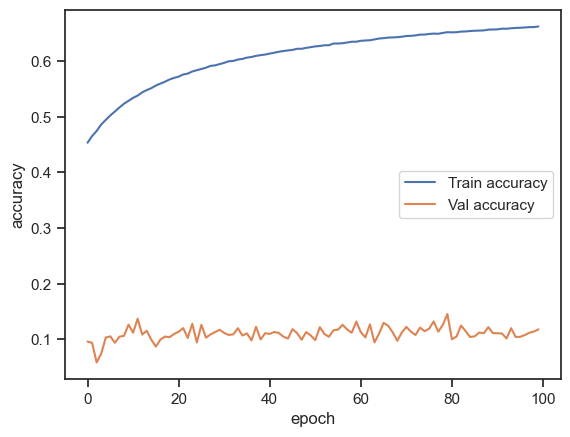

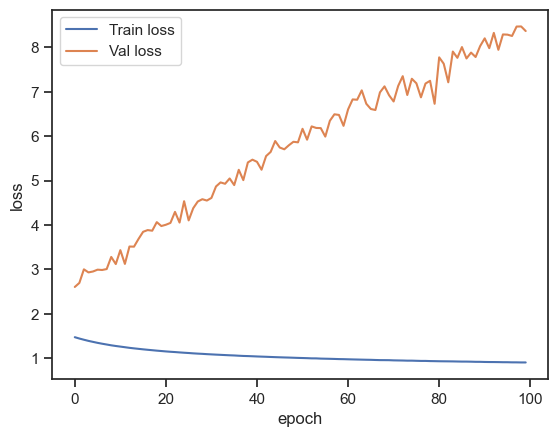

In [358]:
# Answer here
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="ticks")
sns.lineplot(x = training_log.epoch, y = training_log.accuracy, label='Train accuracy')
sns.lineplot(x = training_log.epoch, y = training_log.val_accuracy, label='Val accuracy')
plt.show()

sns.lineplot(x = training_log.epoch, y = training_log.loss, label='Train loss')
sns.lineplot(x = training_log.epoch, y = training_log.val_loss, label='Val loss')
plt.show()

In [359]:
#create a csv with result.csv
list_resid = df_test['id'].tolist()
Ser1_res = pd.Series(list_resid)
Ser2_res = pd.Series(pred_result)
df_res = pd.DataFrame({'id':Ser1_res, 'emotion':Ser2_res})
df_res.to_csv('result.csv', index=False)

In [360]:
#ensure inside result.csv
df_res.shape

(411972, 2)